# Logistic Regression

I decided to treat this as a classification problem by creating a new binary variable affair (did the woman have at least one affair?) and trying to predict the classification for each woman.

#### Dataset

The dataset I chose is the affairs dataset that comes with Statsmodels. It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a 1978 paper from the Journal of Political Economy.

#### Description of Variables

The dataset contains 6366 observations of 9 variables:

rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)

age: woman's age

yrs_married: number of years married

children: number of children

religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)

educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)

occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)

occupation_husb: husband's occupation (same coding as above)

affairs: time spent in extra-marital affairs

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score#, accuracy_score
import seaborn as sns
import pickle
sns.set()
%matplotlib inline

# Import Dataset

In [2]:
dta = sm.datasets.fair.load_pandas().data

In [3]:
#add "affair" column: 1 represents having affairs, 0 represents not 
dta['affair'] = (dta.affairs > 0).astype(int)

In [4]:
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                 religious + educ + C(occupation) + C(occupation_husb)', 
                 dta, return_type="dataframe")

In [5]:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2', 'C(occupation)[T.3.0]':'occ_3', 
                        'C(occupation)[T.4.0]':'occ_4', 'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6', 'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3', 'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5', 'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [6]:
#flatten y
y = np.ravel(y)

# EDA

In [7]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [8]:
X

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
6362,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,32.0,13.0,1.0,1.0,16.0
6363,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,22.0,2.5,0.0,2.0,14.0
6364,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [9]:
# Intercept not needed (only 1 unique value of 1.0 --> adds no info)
X.drop('Intercept', axis=1, inplace=True)

In [10]:
X

,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
6362,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,32.0,13.0,1.0,1.0,16.0
6363,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,22.0,2.5,0.0,2.0,14.0
6364,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [11]:
df_y = pd.DataFrame(data=y, columns=['affair'])
df_y

,affair
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
6361,0.0
6362,0.0
6363,0.0
6364,0.0


In [12]:
df_X_and_y = pd.concat([df_y, X], axis=1)
df_X_and_y

,affair,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
6362,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,32.0,13.0,1.0,1.0,16.0
6363,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,22.0,2.5,0.0,2.0,14.0
6364,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [13]:
df_X_and_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   affair         6366 non-null   float64
 1   occ_2          6366 non-null   float64
 2   occ_3          6366 non-null   float64
 3   occ_4          6366 non-null   float64
 4   occ_5          6366 non-null   float64
 5   occ_6          6366 non-null   float64
 6   occ_husb_2     6366 non-null   float64
 7   occ_husb_3     6366 non-null   float64
 8   occ_husb_4     6366 non-null   float64
 9   occ_husb_5     6366 non-null   float64
 10  occ_husb_6     6366 non-null   float64
 11  rate_marriage  6366 non-null   float64
 12  age            6366 non-null   float64
 13  yrs_married    6366 non-null   float64
 14  children       6366 non-null   float64
 15  religious      6366 non-null   float64
 16  educ           6366 non-null   float64
dtypes: float64(17)
memory usage: 845.6 KB


In [14]:
df_X_and_y.isna().sum()

affair           0
occ_2            0
occ_3            0
occ_4            0
occ_5            0
occ_6            0
occ_husb_2       0
occ_husb_3       0
occ_husb_4       0
occ_husb_5       0
occ_husb_6       0
rate_marriage    0
age              0
yrs_married      0
children         0
religious        0
educ             0
dtype: int64

In [15]:
df_X_and_y.duplicated().sum()

1178

In [16]:
df_X_and_y.drop_duplicates(inplace=True)

In [17]:
df_X_and_y

,affair,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6358,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,27.0,6.0,2.0,4.0,14.0
6361,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
6362,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,32.0,13.0,1.0,1.0,16.0
6364,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [18]:
df_X_and_y.reset_index(inplace=True)
df_X_and_y.drop('index', axis=1, inplace=True)

In [19]:
df_X_and_y

,affair,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5183,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,27.0,6.0,2.0,4.0,14.0
5184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
5185,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,32.0,13.0,1.0,1.0,16.0
5186,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [20]:
corr_ = df_X_and_y.corr()
corr_

,affair,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
affair,1.000000,-0.042841,0.072811,-0.082639,0.057750,0.003283,-0.003074,0.006569,0.007050,0.027458,-0.021306,-0.303572,0.100716,0.163619,0.113608,-0.131451,-0.077702
occ_2,-0.042841,1.000000,-0.336267,-0.266940,-0.160700,-0.059842,0.177356,-0.023975,-0.000017,-0.086852,-0.068143,-0.010833,-0.046207,-0.004945,0.074949,-0.007283,-0.223416
occ_3,0.072811,-0.336267,1.000000,-0.527864,-0.317779,-0.118335,-0.008533,0.100756,-0.000718,0.003947,-0.081263,-0.070084,-0.035939,0.004889,-0.037788,-0.035482,-0.305325
occ_4,-0.082639,-0.266940,-0.527864,1.000000,-0.252264,-0.093938,-0.071561,-0.040141,0.040295,-0.009048,0.070255,0.063875,0.033956,-0.029031,-0.003512,0.037307,0.446671
occ_5,0.057750,-0.160700,-0.317779,-0.252264,1.000000,-0.056552,-0.049276,-0.051580,-0.032215,0.115154,-0.001685,0.013000,0.060487,0.057542,0.008532,0.006107,-0.033921
occ_6,0.003283,-0.059842,-0.118335,-0.093938,-0.056552,1.000000,-0.050042,-0.034570,-0.042028,-0.031904,0.216881,0.019330,0.018052,-0.020325,-0.044176,0.012889,0.235387
occ_husb_2,-0.003074,0.177356,-0.008533,-0.071561,-0.049276,-0.050042,1.000000,-0.154735,-0.332788,-0.312925,-0.164119,-0.035784,-0.054268,-0.030596,0.002172,0.008289,-0.150264
occ_husb_3,0.006569,-0.023975,0.100756,-0.040141,-0.051580,-0.034570,-0.154735,1.000000,-0.200297,-0.188342,-0.098779,-0.009474,-0.000807,-0.005403,-0.020141,0.008711,-0.054283
occ_husb_4,0.007050,-0.000017,-0.000718,0.040295,-0.032215,-0.042028,-0.332788,-0.200297,1.000000,-0.405066,-0.212444,-0.008178,-0.023606,-0.004057,0.016996,-0.007897,-0.025831
occ_husb_5,0.027458,-0.086852,0.003947,-0.009048,0.115154,-0.031904,-0.312925,-0.188342,-0.405066,1.000000,-0.199764,-0.009846,0.102810,0.091491,0.055827,0.001253,0.024771


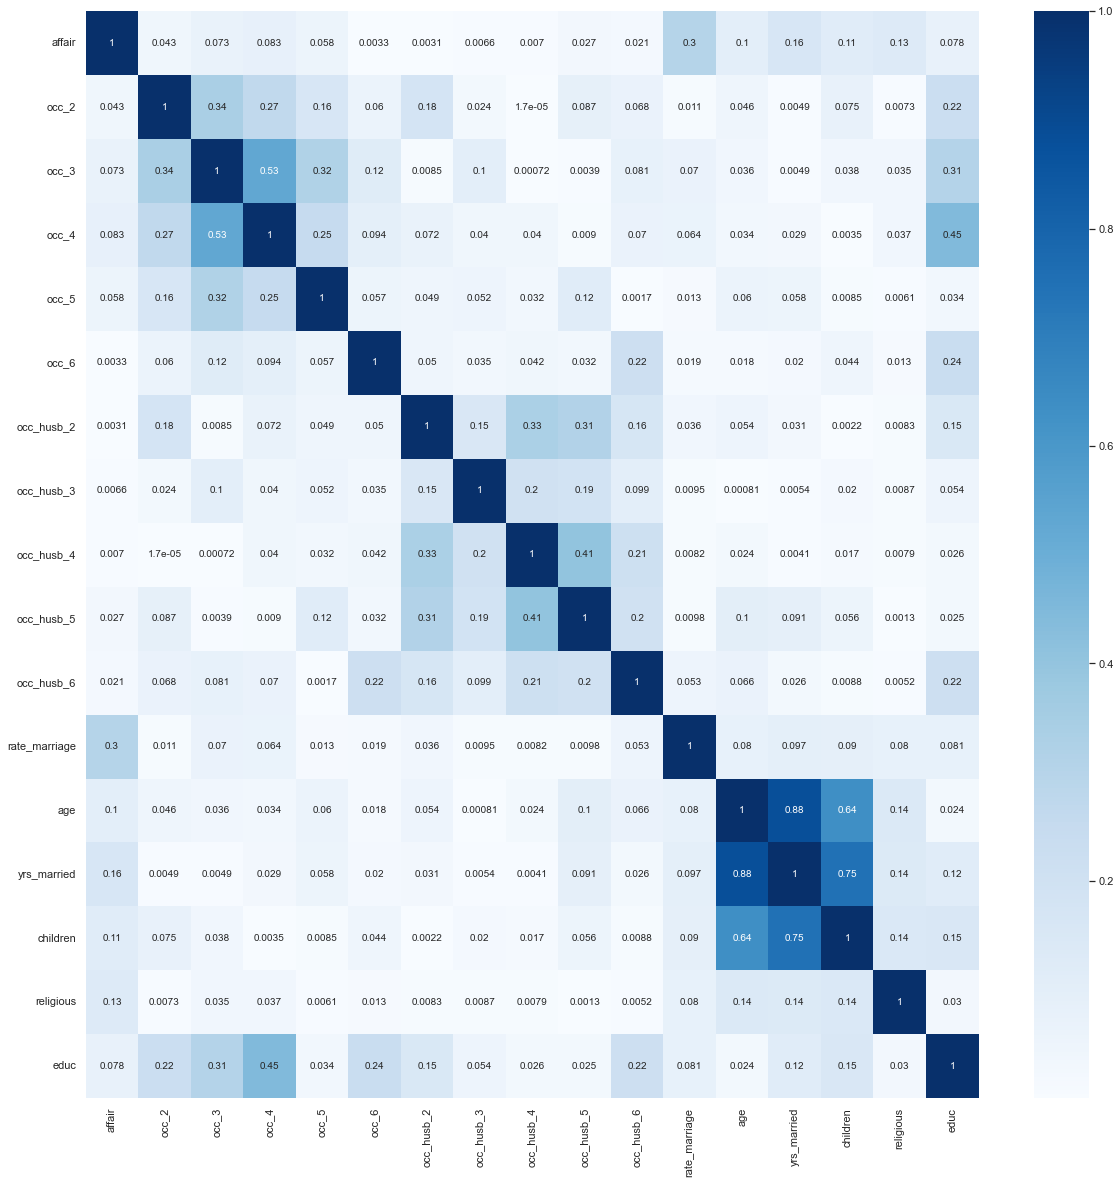

In [21]:
#absolute value of corr (for ranking purposes)
plt.figure(figsize=(20, 20))
sns.heatmap(abs(corr_), annot=True, cmap="Blues", fmt='.2g')
plt.show()
#strong correlation between potential independent vars children, age, and yrs_married (potential multicollinearity when modeling)

In [22]:
#ranked (absolute value) correlations of independent vars to affair (target var)
df_corr_ranked = abs(corr_['affair']).rank()
df_corr_ranked

affair           17.0
occ_2             7.0
occ_3             9.0
occ_4            11.0
occ_5             8.0
occ_6             2.0
occ_husb_2        1.0
occ_husb_3        3.0
occ_husb_4        4.0
occ_husb_5        6.0
occ_husb_6        5.0
rate_marriage    16.0
age              12.0
yrs_married      15.0
children         13.0
religious        14.0
educ             10.0
Name: affair, dtype: float64

In [23]:
rank = df_corr_ranked.values
var = df_corr_ranked.index.values
corr_ranked_and_sorted = sorted([(-(rank[i]-(len(rank) + 1)), var[i]) for i in range(len(rank))])
corr_ranked_and_sorted

[(1.0, 'affair'),
 (2.0, 'rate_marriage'),
 (3.0, 'yrs_married'),
 (4.0, 'religious'),
 (5.0, 'children'),
 (6.0, 'age'),
 (7.0, 'occ_4'),
 (8.0, 'educ'),
 (9.0, 'occ_3'),
 (10.0, 'occ_5'),
 (11.0, 'occ_2'),
 (12.0, 'occ_husb_5'),
 (13.0, 'occ_husb_6'),
 (14.0, 'occ_husb_4'),
 (15.0, 'occ_husb_3'),
 (16.0, 'occ_6'),
 (17.0, 'occ_husb_2')]

## Check for Imbalanced Classes

In [24]:
cols = df_X_and_y.columns.values
cols

array(['affair', 'occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6',
       'occ_husb_2', 'occ_husb_3', 'occ_husb_4', 'occ_husb_5',
       'occ_husb_6', 'rate_marriage', 'age', 'yrs_married', 'children',
       'religious', 'educ'], dtype=object)

In [25]:
# redefine X (with dropped duplicates)
X = df_X_and_y[cols[1:]]
X

,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5183,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,27.0,6.0,2.0,4.0,14.0
5184,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
5185,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,32.0,13.0,1.0,1.0,16.0
5186,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [26]:
# redefine y (with dropped duplicates)
y = df_X_and_y['affair']
y

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
5183    0.0
5184    0.0
5185    0.0
5186    0.0
5187    0.0
Name: affair, Length: 5188, dtype: float64

In [27]:
uniq, counts = np.unique(y, return_counts=True)
uniq, counts

(array([0., 1.]), array([3305, 1883], dtype=int64))

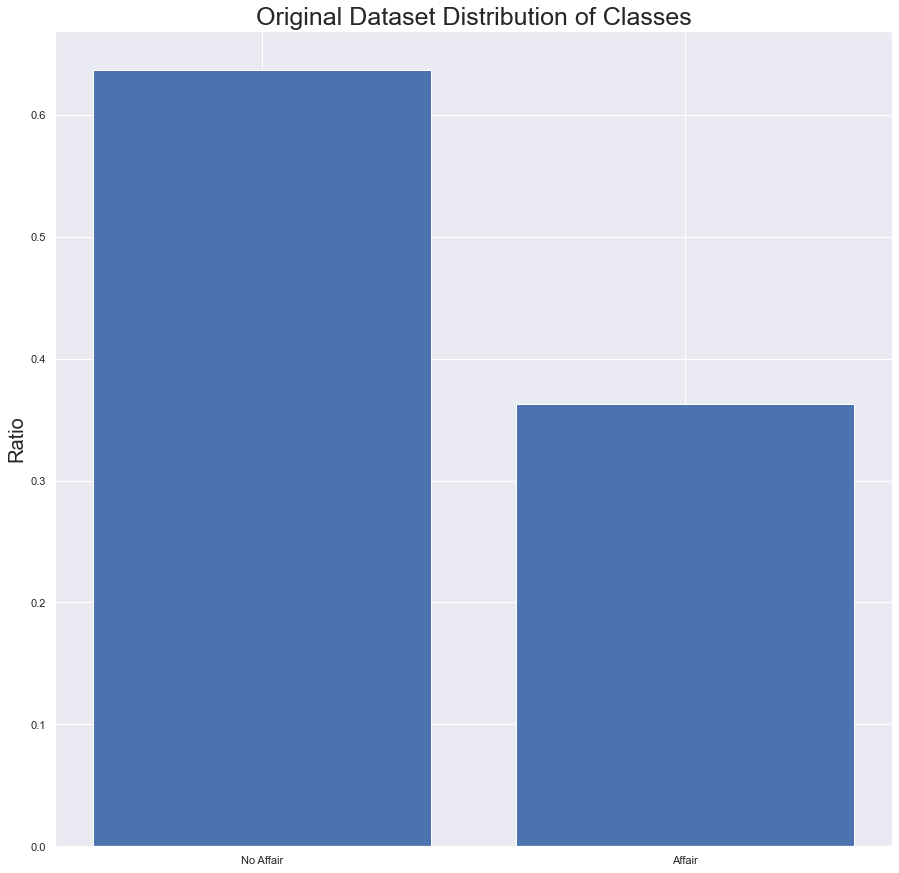

In [28]:
# original dataset
total_ct = sum(counts)
fig, ax = plt.subplots(figsize = (15,15))
plt.bar(['No Affair', 'Affair'], height = counts/total_ct)
ax.set_ylabel('Ratio', fontsize = 20)
ax.set_title('Original Dataset Distribution of Classes', fontsize = 25)
plt.show()
#slight imbalance, but not egregious

# Data Preparation

In [29]:
vif1 = pd.DataFrame()
vif1["vif"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif1["Features"] = X.columns

#check the VIF values (VIF > 10 to be removed)
vif1
# remove age

,vif,Features
0,10.765304,occ_2
1,27.847684,occ_3
2,23.978050,occ_4
3,10.333995,occ_5
4,2.822852,occ_6
5,6.211244,occ_husb_2
6,3.177038,occ_husb_3
7,8.633671,occ_husb_4
8,8.153230,occ_husb_5
9,3.539621,occ_husb_6


### Age

In [30]:
cols_x = X.columns.values
cols_x

array(['occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_husb_2',
       'occ_husb_3', 'occ_husb_4', 'occ_husb_5', 'occ_husb_6',
       'rate_marriage', 'age', 'yrs_married', 'children', 'religious',
       'educ'], dtype=object)

In [31]:
idx_age = np.where(cols_x == 'age')
idx_age

(array([11], dtype=int64),)

In [32]:
cols1 = list(cols_x[:10]) + list(cols_x[12:])
cols1

['occ_2',
 'occ_3',
 'occ_4',
 'occ_5',
 'occ_6',
 'occ_husb_2',
 'occ_husb_3',
 'occ_husb_4',
 'occ_husb_5',
 'occ_husb_6',
 'yrs_married',
 'children',
 'religious',
 'educ']

In [33]:
X1 = X[cols1]

In [34]:
vif2 = pd.DataFrame()
vif2["vif"] = [variance_inflation_factor(X1, i) for i in range(X1.shape[1])]
vif2["Features"] = X1.columns

#check the VIF values
vif2
# remove educ

,vif,Features
0,8.848075,occ_2
1,22.685444,occ_3
2,20.511500,occ_4
3,8.588477,occ_5
4,2.610498,occ_6
5,6.103919,occ_husb_2
6,3.120374,occ_husb_3
7,8.490833,occ_husb_4
8,7.990864,occ_husb_5
9,3.480122,occ_husb_6


### Educ

In [35]:
idx_educ = cols1.index('educ')
idx_educ

13

In [36]:
cols2 = cols1[:13]
cols2

['occ_2',
 'occ_3',
 'occ_4',
 'occ_5',
 'occ_6',
 'occ_husb_2',
 'occ_husb_3',
 'occ_husb_4',
 'occ_husb_5',
 'occ_husb_6',
 'yrs_married',
 'children',
 'religious']

In [37]:
X2 = X[cols2]

In [38]:
vif3 = pd.DataFrame()
vif3["vif"] = [variance_inflation_factor(X2, i) for i in range(X2.shape[1])]
vif3["Features"] = X2.columns

#check the VIF values
vif3
# remove occ_3

,vif,Features
0,5.130382,occ_2
1,12.042777,occ_3
2,9.123186,occ_4
3,4.714804,occ_5
4,1.628693,occ_6
5,6.041351,occ_husb_2
6,3.082476,occ_husb_3
7,8.338695,occ_husb_4
8,7.812762,occ_husb_5
9,3.344621,occ_husb_6


### Occ_3

In [39]:
idx_occ_3 = cols2.index('occ_3')
idx_occ_3

1

In [40]:
cols3 = cols2[:1] + cols2[2:]
cols3

['occ_2',
 'occ_4',
 'occ_5',
 'occ_6',
 'occ_husb_2',
 'occ_husb_3',
 'occ_husb_4',
 'occ_husb_5',
 'occ_husb_6',
 'yrs_married',
 'children',
 'religious']

In [41]:
X3 = X[cols3]

In [42]:
vif4 = pd.DataFrame()
vif4["vif"] = [variance_inflation_factor(X3, i) for i in range(X3.shape[1])]
vif4["Features"] = X3.columns

#check the VIF values
vif4

,vif,Features
0,1.390566,occ_2
1,1.706195,occ_4
2,1.328681,occ_5
3,1.106868,occ_6
4,2.562923,occ_husb_2
5,1.605169,occ_husb_3
6,3.232049,occ_husb_4
7,3.153825,occ_husb_5
8,1.823000,occ_husb_6
9,6.471078,yrs_married


All the remaining VIF values are less than 10. That means no multicollinearity (based on the set threshold). Now, we can go ahead with fitting our data to the model. Before that, let's split our data in test and training set.


### Train-test split

In [43]:
X3

,occ_2,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,yrs_married,children,religious
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,3.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.0,3.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.5,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,16.5,4.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,4.0
5184,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.0,2.0,3.0
5185,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0,1.0,1.0
5186,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,1.0,3.0


In [44]:
y

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
5183    0.0
5184    0.0
5185    0.0
5186    0.0
5187    0.0
Name: affair, Length: 5188, dtype: float64

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X3 , y, test_size=0.2, train_size=0.8, random_state = 355)

In [46]:
#train
x_train, y_train

(      occ_2  occ_4  occ_5  occ_6  occ_husb_2  occ_husb_3  occ_husb_4  \
 4787    0.0    0.0    1.0    0.0         0.0         0.0         0.0   
 535     0.0    0.0    0.0    0.0         0.0         0.0         0.0   
 4927    1.0    0.0    0.0    0.0         0.0         0.0         0.0   
 4191    1.0    0.0    0.0    0.0         0.0         0.0         1.0   
 543     1.0    0.0    0.0    0.0         0.0         1.0         0.0   
 ...     ...    ...    ...    ...         ...         ...         ...   
 4083    0.0    1.0    0.0    0.0         0.0         0.0         1.0   
 3985    0.0    0.0    0.0    0.0         0.0         0.0         1.0   
 2099    0.0    0.0    0.0    0.0         0.0         0.0         0.0   
 3418    0.0    0.0    1.0    0.0         1.0         0.0         0.0   
 2690    0.0    1.0    0.0    0.0         0.0         0.0         0.0   
 
       occ_husb_5  occ_husb_6  yrs_married  children  religious  
 4787         1.0         0.0          9.0       1.0    

In [47]:
#test
x_test, y_test

(      occ_2  occ_4  occ_5  occ_6  occ_husb_2  occ_husb_3  occ_husb_4  \
 1949    0.0    1.0    0.0    0.0         0.0         0.0         1.0   
 4765    0.0    0.0    0.0    0.0         0.0         0.0         0.0   
 4242    0.0    0.0    0.0    0.0         0.0         0.0         1.0   
 4433    0.0    0.0    0.0    0.0         0.0         0.0         1.0   
 1756    0.0    0.0    0.0    0.0         0.0         0.0         0.0   
 ...     ...    ...    ...    ...         ...         ...         ...   
 168     0.0    0.0    0.0    0.0         0.0         0.0         1.0   
 131     0.0    1.0    0.0    0.0         0.0         0.0         0.0   
 2323    0.0    0.0    1.0    0.0         0.0         0.0         0.0   
 1818    0.0    0.0    0.0    0.0         0.0         1.0         0.0   
 3732    0.0    0.0    0.0    0.0         0.0         0.0         1.0   
 
       occ_husb_5  occ_husb_6  yrs_married  children  religious  
 1949         0.0         0.0          2.5       0.0    

# Modeling

In [48]:
#class_weight = 'balanced' to compensate for imbalanced classes
log_reg = LogisticRegression(class_weight='balanced')

log_reg.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

In [49]:
#train accuracy score
log_reg.score(x_train, y_train)

0.6074698795180723

In [50]:
#test accuracy score
log_reg.score(x_test, y_test)

0.5963391136801541

In [51]:
y_train_flat = np.ravel(y_train)
y_test_flat = np.ravel(y_test)

In [52]:
# test cross-validation score
cross_val_score_test = cross_val_score(log_reg, x_test, y_test_flat, cv=10)
cross_val_score_test

array([0.52884615, 0.58653846, 0.61538462, 0.55769231, 0.61538462,
       0.625     , 0.58653846, 0.53846154, 0.67961165, 0.59223301])

In [53]:
sum(cross_val_score_test)/len(cross_val_score_test)

0.5925690814040327

In [54]:
# train cross-validation score
cross_val_score_train = cross_val_score(log_reg, x_train, y_train_flat, cv=10)
cross_val_score_train

array([0.57831325, 0.61445783, 0.6       , 0.62409639, 0.61445783,
       0.59036145, 0.58554217, 0.61686747, 0.63855422, 0.58313253])

In [55]:
sum(cross_val_score_train)/len(cross_val_score_train)

0.604578313253012

In [56]:
y_pred_test = log_reg.predict(x_test)

In [57]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_test)
conf_mat

array([[414, 265],
       [154, 205]], dtype=int64)

In [58]:
true_positive = conf_mat[0][0]
false_positive = conf_mat[0][1]
false_negative = conf_mat[1][0]
true_negative = conf_mat[1][1]

In [59]:
# Breaking down the formula for Accuracy
Accuracy = (true_positive + true_negative) / (true_positive +false_positive + false_negative + true_negative)
Accuracy

0.5963391136801541

In [60]:
# Precison
Precision = true_positive/(true_positive+false_positive)
Precision

0.6097201767304861

In [61]:
# Recall
Recall = true_positive/(true_positive + false_negative)
Recall

0.7288732394366197

In [62]:
# F1 Score
F1_Score = 2 * (Recall * Precision) / (Recall + Precision)
F1_Score

0.6639935846030474

In [63]:
# Area Under Curve
auc = roc_auc_score(y_test, y_pred_test)
auc
#this model is barely better than random guessing...

0.5903754086995049

**ROC**

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

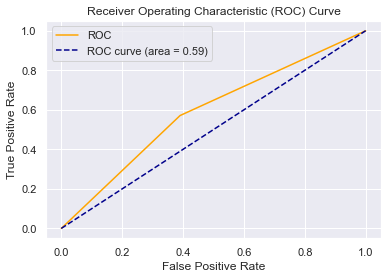

In [65]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Save Model

In [66]:
# save model
with open('log_reg_model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)

In [67]:
#Conclusion: this model is slightly better than random guessing based on the ROC curve and AUC
#use as baseline model to compare to subsequent models, decent start...